In [1]:
import os
import sys
home_dir = "../../"
module_path = os.path.abspath(os.path.join(home_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr

from models.aa_common.data_loader import get_population_freq_SNVs

import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
def filter_dbnsfp_preds(x):
    if x==".": return False
    elif ".;" in x: return False
    else: return True

In [3]:
variants_df = get_population_freq_SNVs(home_dir)


Log: Loading data ...
(95324, 13)
Index(['snp_id', 'chrom_acc_version', 'chrom_pos', 'ref_allele', 'alt_allele',
       'prot_acc_version', 'prot_pos', 'wt', 'mut', 'wt_population',
       'mut_poulation', 'wt_freq', 'mt_freq'],
      dtype='object')
After combining common (18295), rare (29468) and sampled-singletons (48535), data: (95324, 13)
NP_001277137.1    95
NP_001291317.1    78
NP_002115.2       74
NP_112241.2       68
NP_001075106.2    65
                  ..
NP_663745.1        1
NP_002699.1        1
NP_057588.1        1
NP_002280.1        1
NP_065171.2        1
Name: prot_acc_version, Length: 14997, dtype: int64


In [7]:
pred_df = pd.read_csv(home_dir+"models/dbnsfp/outputs/chromosomal_SNVs_preds.txt", sep="\t")
print(f"#-of SNVs found from dbNSFP: {pred_df.shape[0]}")

variants_df["chrom"] = variants_df["chrom_acc_version"].apply(lambda x: int(x[x.index("_")+1:x.index(".")])) # taking only chromosom number for dbNSFP inputs

print("Log: merging dbNSFP prediction scores with ground truth population freq data ...")
result_df = pred_df.merge(variants_df, how="left", left_on=["#chr", "pos(1-based)", "ref", "alt"], right_on=["chrom", "chrom_pos", "ref_allele", "alt_allele"])
# result_df = variants_df.merge(pred_df, how="left", left_on=["chrom", "chrom_pos", "ref_allele", "alt_allele"], right_on=["#chr", "pos(1-based)", "ref", "alt"])
print(result_df.columns)



#-of SNVs found from dbNSFP: 89958
Log: merging dbNSFP prediction scores with ground truth population freq data ...
Index(['#chr', 'pos(1-based)', 'ref', 'alt', 'aaref', 'aaalt', 'MetaRNN_score',
       'MetaRNN_rankscore', 'MetaRNN_pred', 'MVP_score', 'MVP_rankscore',
       'snp_id', 'chrom_acc_version', 'chrom_pos', 'ref_allele', 'alt_allele',
       'prot_acc_version', 'prot_pos', 'wt', 'mut', 'wt_population',
       'mut_poulation', 'wt_freq', 'mt_freq', 'chrom'],
      dtype='object')


,snp_id,chrom_acc_version,chrom_pos,ref_allele,alt_allele,prot_acc_version,prot_pos,wt,mut,wt_population,mut_poulation,wt_freq,mt_freq
0,rs923250954,NC_000001.11,3463094,C,T,NP_055263.2,4,R,W,14050,1,0.999929,0.000071
1,rs183210126,NC_000001.11,3463266,G,A,NP_055263.2,61,R,Q,49226,293,0.994083,0.005917
2,rs533341228,NC_000001.11,3463442,C,T,NP_055263.2,120,R,W,15150,1,0.999934,0.000066
3,rs1380483330,NC_000001.11,3463556,A,G,NP_055263.2,158,M,V,14050,1,0.999929,0.000071
4,rs1265378138,NC_000001.11,3467194,G,A,NP_055263.2,221,E,K,8988,1,0.999889,0.000111
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90098,rs762468635,NC_000009.12,137614574,C,T,NP_689498.1,271,P,S,14050,1,0.999929,0.000071
90099,rs72765183,NC_000009.12,137614623,A,C,NP_689498.1,287,N,T,149688,3602,0.976502,0.023498
90100,rs151308611,NC_000009.12,137614757,G,A,NP_689498.1,332,V,I,138258,409,0.997050,0.002950
90101,rs113469851,NC_000009.12,137614787,C,T,NP_689498.1,342,R,W,135666,154,0.998866,0.001134


In [5]:
not_found_snvs_df = pd.read_csv(home_dir+"models/dbnsfp/outputs/chromosomal_SNVs_preds.txt.err", sep="\t")
print(f"#-of SNVs not found: {not_found_snvs_df.shape[0]}")

#-of SNVs not found: 6033


In [13]:
metaRNN_scores_df = result_df[result_df["MetaRNN_score"].apply(filter_dbnsfp_preds)] # removing those comparisons that does not produce any result
print(f"Log: MetaRNN rank correlations for {metaRNN_scores_df.shape[0]} SNVs")
metaRNN_scores = metaRNN_scores_df["MetaRNN_score"].apply(lambda x: float(x.split(";")[0])) # can have multiple scores, ie '0.4573521;0.4573521;0.4573521;0.4573521'. taking 1st one
result_df["pred"] = metaRNN_scores
metaRNN_result_df = result_df[['snp_id', 'chrom_acc_version', 'chrom_pos', 'ref_allele', 'alt_allele', 'prot_acc_version', 'prot_pos', 'wt', 'mut', 'wt_population','mut_poulation', 'wt_freq', 'mt_freq', "pred"]]
# print("\t", spearmanr(metaRNN_scores, metaRNN_scores_df["mt_freq"]))
# print("\t", pearsonr(metaRNN_scores, metaRNN_scores_df["mt_freq"]))

Log: MetaRNN rank correlations for 89854 SNVs


,snp_id,chrom_acc_version,chrom_pos,ref_allele,alt_allele,prot_acc_version,prot_pos,wt,mut,wt_population,mut_poulation,wt_freq,mt_freq,pred
0,rs923250954,NC_000001.11,3463094,C,T,NP_055263.2,4,R,W,14050,1,0.999929,0.000071,0.107802
1,rs183210126,NC_000001.11,3463266,G,A,NP_055263.2,61,R,Q,49226,293,0.994083,0.005917,0.003110
2,rs533341228,NC_000001.11,3463442,C,T,NP_055263.2,120,R,W,15150,1,0.999934,0.000066,0.167473
3,rs1380483330,NC_000001.11,3463556,A,G,NP_055263.2,158,M,V,14050,1,0.999929,0.000071,0.046468
4,rs1265378138,NC_000001.11,3467194,G,A,NP_055263.2,221,E,K,8988,1,0.999889,0.000111,0.571189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90098,rs762468635,NC_000009.12,137614574,C,T,NP_689498.1,271,P,S,14050,1,0.999929,0.000071,0.637872
90099,rs72765183,NC_000009.12,137614623,A,C,NP_689498.1,287,N,T,149688,3602,0.976502,0.023498,0.003810
90100,rs151308611,NC_000009.12,137614757,G,A,NP_689498.1,332,V,I,138258,409,0.997050,0.002950,0.003824
90101,rs113469851,NC_000009.12,137614787,C,T,NP_689498.1,342,R,W,135666,154,0.998866,0.001134,0.003050


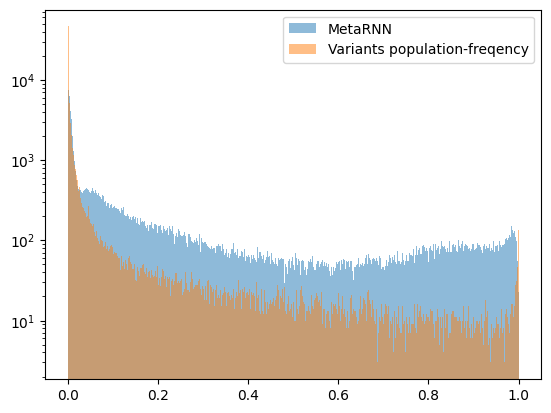

In [14]:
processed_result_df = metaRNN_scores_df.copy()
metaRNN_scores=(metaRNN_scores-metaRNN_scores.min())/(metaRNN_scores.max()-metaRNN_scores.min())
processed_result_df["mt_freq"]=(metaRNN_scores_df["mt_freq"]-metaRNN_scores_df["mt_freq"].min())/(metaRNN_scores_df["mt_freq"].max()-metaRNN_scores_df["mt_freq"].min())
plt.hist(metaRNN_scores, bins=500, log=True, alpha=.5, label="MetaRNN")
plt.hist(processed_result_df["mt_freq"], bins=500, log=True, alpha=.5, label="Variants population-freqency")
plt.legend()
plt.show()

In [15]:
mvp_scores_df = result_df[result_df["MVP_score"].apply(filter_dbnsfp_preds)] # removing those comparisons that does not produce any result
print(f"Log: MVP rank correlations for {mvp_scores_df.shape[0]} SNVs")
mvp_scores = mvp_scores_df["MVP_score"].apply(lambda x: float(x.split(";")[0]))
print("\t", spearmanr(mvp_scores, mvp_scores_df["mt_freq"]))
print("\t", pearsonr(mvp_scores, mvp_scores_df["mt_freq"]))

Log: MVP rank correlations for 70173 SNVs
	 SignificanceResult(statistic=-0.14992699082658775, pvalue=0.0)
	 PearsonRResult(statistic=-0.06768912751565842, pvalue=4.69249449663957e-72)


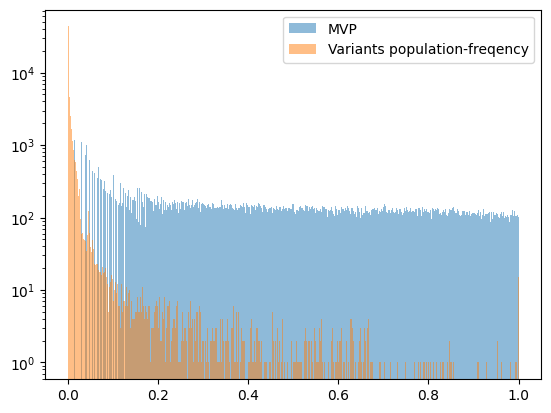

In [16]:
processed_result_df = mvp_scores_df.copy()
metaRNN_scores=(mvp_scores-mvp_scores.min())/(mvp_scores.max()-mvp_scores.min())
processed_result_df["mt_freq"]=(metaRNN_scores_df["mt_freq"]-metaRNN_scores_df["mt_freq"].min())/(metaRNN_scores_df["mt_freq"].max()-metaRNN_scores_df["mt_freq"].min())
plt.hist(mvp_scores, bins=500, log=True, alpha=.5, label="MVP")
plt.hist(processed_result_df["mt_freq"], bins=500, log=True, alpha=.5, label="Variants population-freqency")
plt.legend()
plt.show()